# Brain Tumor Detection with YOLOv11
## Complete Pipeline: Preprocessing + Enhanced Training

**Project:** DS3001 
**Goal:** Achieve 85%+ mAP@0.5 using research-optimized approach

### Pipeline Overview:
1. **Dataset Exploration** - Understand the MRI dataset structure
2. **CLAHE Preprocessing** - Enhance image contrast for better tumor visibility
3. **Baseline Training** - YOLOv11n with standard hyperparameters
4. **Enhanced Training** - Research-optimized configuration
5. **Results Analysis** - Compare performance metrics

## 1. Setup and Imports

In [5]:
# Import required libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import shutil
import torch
from ultralytics import YOLO
import pandas as pd
import seaborn as sns
from PIL import Image

# Set style for plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Display versions
print(f"PyTorch: {torch.__version__}")
print(f"OpenCV: {cv2.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")

# Set paths
PROJECT_ROOT = Path.cwd()
DATA_DIR = PROJECT_ROOT / "DATA"
OUTPUT_DIR = PROJECT_ROOT / "OUTPUT"
OUTPUT_DIR.mkdir(exist_ok=True)

print(f"\n✓ Setup complete!")
print(f"Project Root: {PROJECT_ROOT}")
print(f"Data Directory: {DATA_DIR}")

PyTorch: 2.5.1+cu121
OpenCV: 4.12.0
CUDA Available: True
CUDA Device: NVIDIA GeForce RTX 3060

✓ Setup complete!
Project Root: c:\Users\trann\OneDrive\Documents\Brain-Tumor-DS4002
Data Directory: c:\Users\trann\OneDrive\Documents\Brain-Tumor-DS4002\DATA


## 2. Dataset Exploration

In [6]:
# Check dataset structure
train_images = DATA_DIR / "images" / "train"
val_images = DATA_DIR / "images" / "val"
train_labels = DATA_DIR / "labels" / "train"
val_labels = DATA_DIR / "labels" / "val"

# Count images
train_count = len(list(train_images.glob("*.jpg")))
val_count = len(list(val_images.glob("*.jpg")))
train_label_count = len(list(train_labels.glob("*.txt")))
val_label_count = len(list(val_labels.glob("*.txt")))

print("Dataset Summary:")
print("="*50)
print(f"Training Images:   {train_count}")
print(f"Training Labels:   {train_label_count}")
print(f"Validation Images: {val_count}")
print(f"Validation Labels: {val_label_count}")
print(f"Total Images:      {train_count + val_count}")
print("="*50)

# Load sample image and check properties
sample_img_path = list(train_images.glob("*.jpg"))[0]
sample_img = Image.open(sample_img_path)
sample_array = np.array(sample_img)

print(f"\nSample Image: {sample_img_path.name}")
print(f"Size: {sample_img.size}")
print(f"Mode: {sample_img.mode}")
print(f"Array shape: {sample_array.shape}")
print(f"Data type: {sample_array.dtype}")
print(f"Value range: {sample_array.min()}-{sample_array.max()}")

Dataset Summary:
Training Images:   893
Training Labels:   878
Validation Images: 223
Validation Labels: 223
Total Images:      1116

Sample Image: 00054_145.jpg
Size: (512, 512)
Mode: L
Array shape: (512, 512)
Data type: uint8
Value range: 0-255


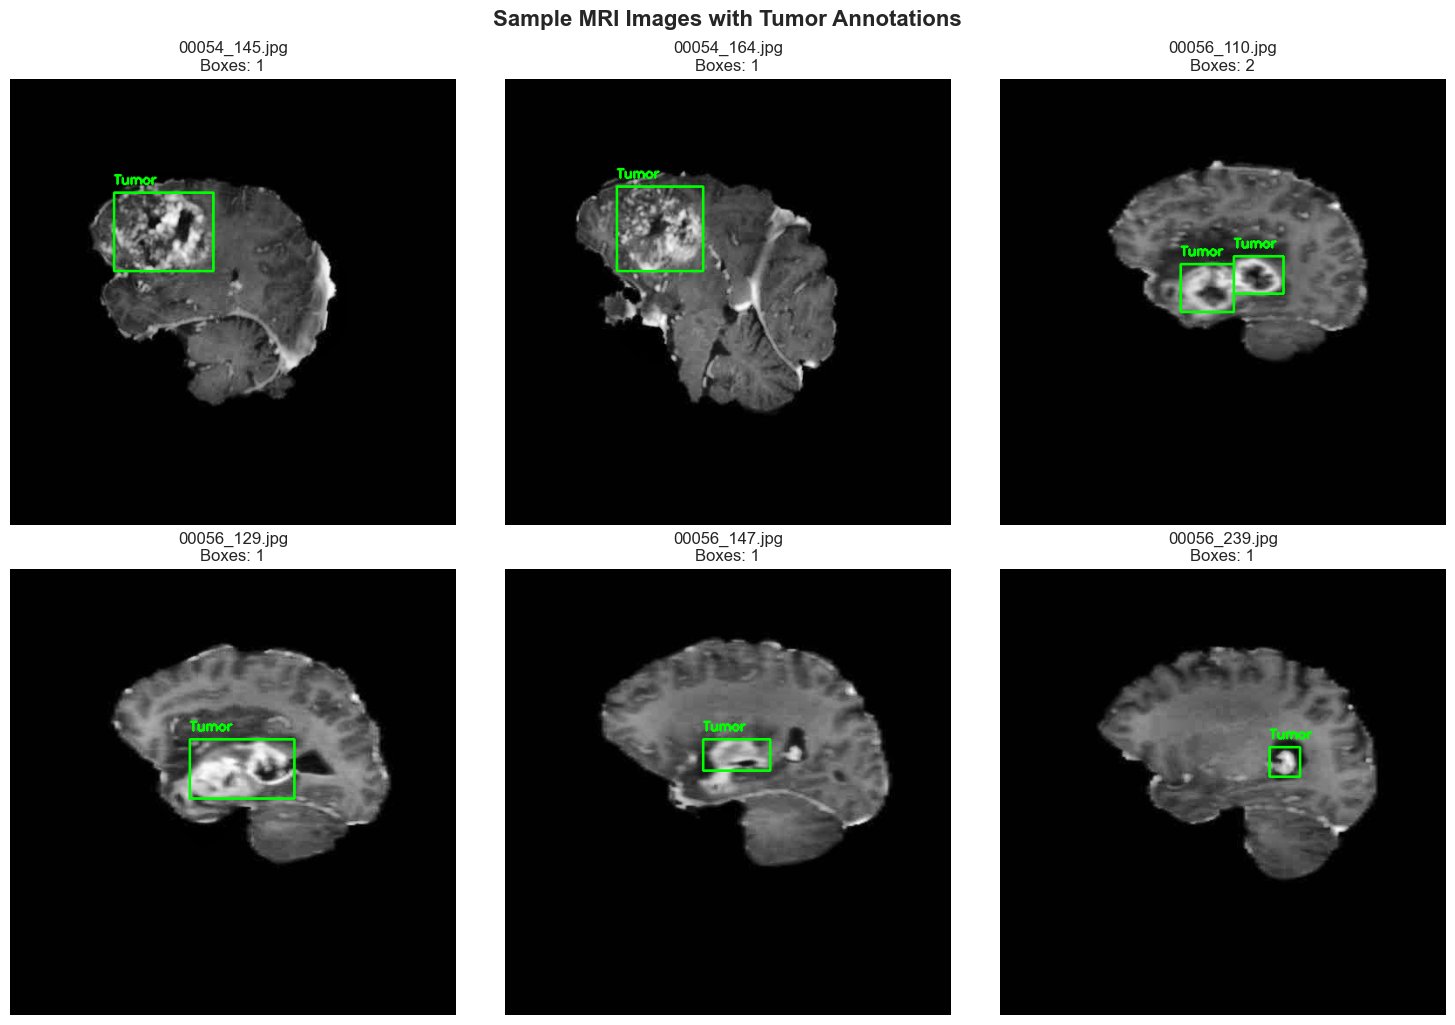

In [7]:
# Visualize sample images with labels
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

sample_images = list(train_images.glob("*.jpg"))[:6]

for idx, img_path in enumerate(sample_images):
    # Load image
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    
    # Load corresponding label
    label_path = train_labels / f"{img_path.stem}.txt"
    
    # Draw on image copy
    img_display = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    if label_path.exists():
        with open(label_path, 'r') as f:
            lines = f.readlines()
        
        h, w = img.shape[:2] if len(img.shape) == 3 else img.shape
        for line in lines:
            class_id, x_center, y_center, width, height = map(float, line.strip().split())
            
            # Convert normalized coordinates to pixel coordinates
            x1 = int((x_center - width/2) * w)
            y1 = int((y_center - height/2) * h)
            x2 = int((x_center + width/2) * w)
            y2 = int((y_center + height/2) * h)
            
            # Draw bounding box
            color = (0, 255, 0) if class_id == 1 else (255, 0, 0)
            cv2.rectangle(img_display, (x1, y1), (x2, y2), color, 2)
            
            label = "Tumor" if class_id == 1 else "Negative"
            cv2.putText(img_display, label, (x1, y1-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    axes[idx].imshow(img_display)
    axes[idx].set_title(f"{img_path.name}\nBoxes: {len(lines) if label_path.exists() else 0}")
    axes[idx].axis('off')

plt.tight_layout()
plt.suptitle("Sample MRI Images with Tumor Annotations", y=1.02, fontsize=16, fontweight='bold')
plt.show()

## 3. CLAHE Preprocessing
### Contrast Limited Adaptive Histogram Equalization for Medical Imaging

In [8]:
# Define CLAHE preprocessing function
def preprocess_image_clahe(image_path, output_path=None):
    """
    Apply CLAHE preprocessing to enhance tumor visibility
    
    Args:
        image_path: Path to input image
        output_path: Path to save processed image (optional)
    
    Returns:
        enhanced: Processed image
    """
    # Read grayscale image
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        print(f"Warning: Could not read {image_path}")
        return None
    
    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(img)
    
    # Normalize intensity to full range
    enhanced = cv2.normalize(enhanced, None, 0, 255, cv2.NORM_MINMAX)
    
    # Save if output path provided
    if output_path:
        cv2.imwrite(str(output_path), enhanced)
    
    return enhanced

# Test CLAHE on sample image
sample_original = cv2.imread(str(sample_img_path), cv2.IMREAD_GRAYSCALE)
sample_enhanced = preprocess_image_clahe(sample_img_path)

print("✓ CLAHE preprocessing function defined")
print(f"Original range: {sample_original.min()}-{sample_original.max()}")
print(f"Enhanced range: {sample_enhanced.min()}-{sample_enhanced.max()}")

✓ CLAHE preprocessing function defined
Original range: 0-255
Enhanced range: 0-255


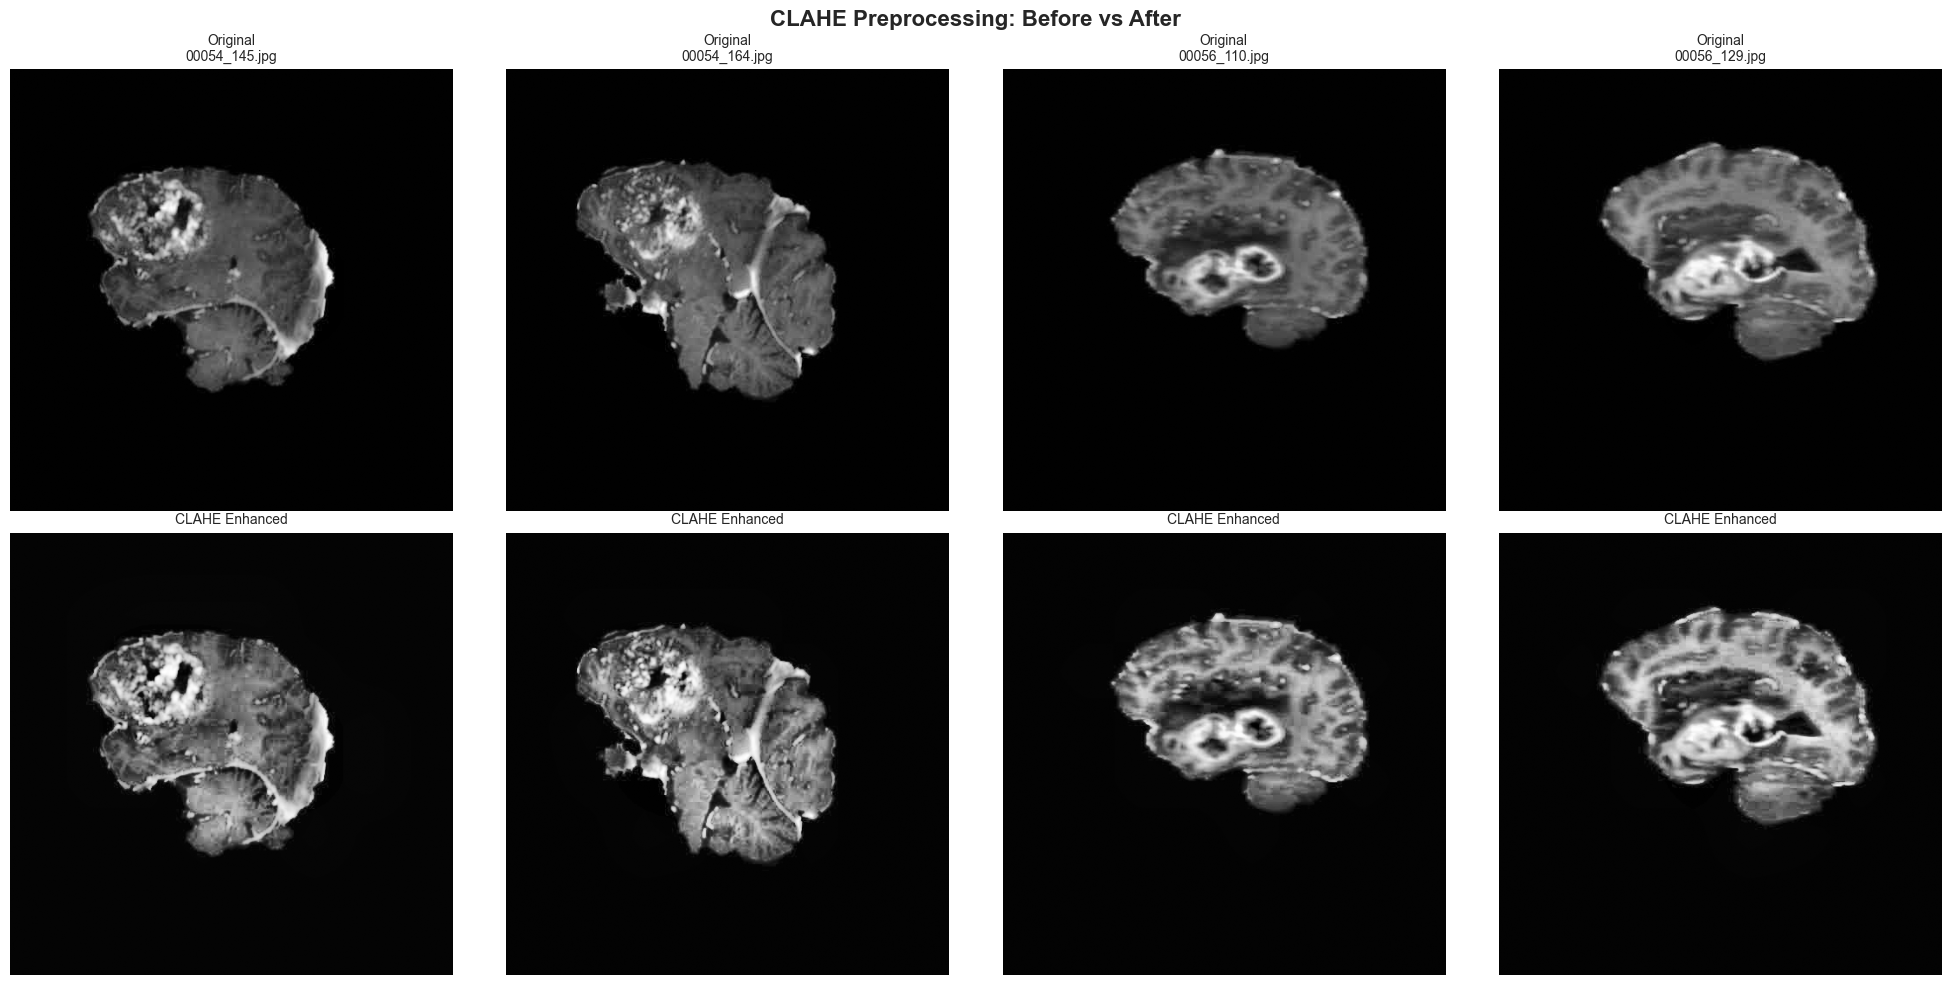

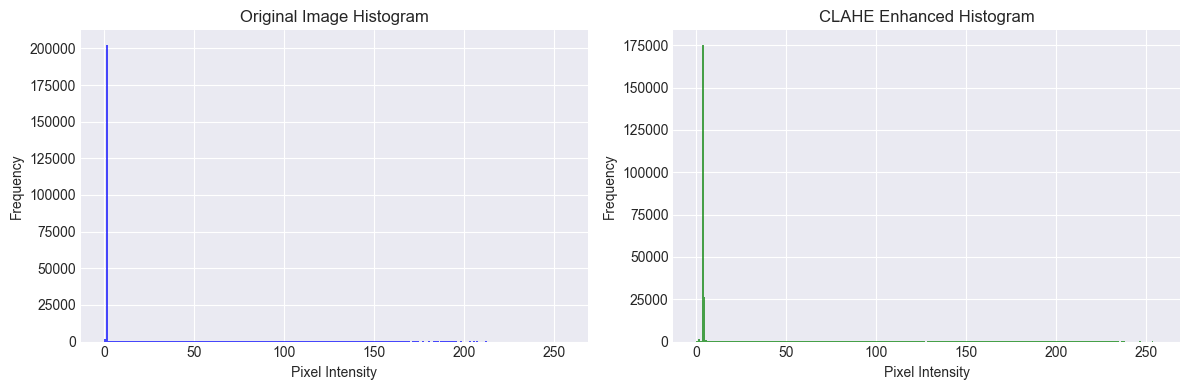

In [9]:
# Visualize CLAHE effect (Before vs After)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

sample_paths = list(train_images.glob("*.jpg"))[:4]

for idx, img_path in enumerate(sample_paths):
    # Load original
    original = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    
    # Apply CLAHE
    enhanced = preprocess_image_clahe(img_path)
    
    # Plot original
    axes[0, idx].imshow(original, cmap='gray')
    axes[0, idx].set_title(f'Original\n{img_path.name}', fontsize=10)
    axes[0, idx].axis('off')
    
    # Plot enhanced
    axes[1, idx].imshow(enhanced, cmap='gray')
    axes[1, idx].set_title(f'CLAHE Enhanced', fontsize=10)
    axes[1, idx].axis('off')

plt.suptitle("CLAHE Preprocessing: Before vs After", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Show histogram comparison for first image
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(original.ravel(), bins=256, range=(0, 256), color='blue', alpha=0.7)
axes[0].set_title('Original Image Histogram')
axes[0].set_xlabel('Pixel Intensity')
axes[0].set_ylabel('Frequency')

axes[1].hist(enhanced.ravel(), bins=256, range=(0, 256), color='green', alpha=0.7)
axes[1].set_title('CLAHE Enhanced Histogram')
axes[1].set_xlabel('Pixel Intensity')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [10]:
# Apply CLAHE preprocessing to entire dataset
def preprocess_dataset(backup=True):
    """
    Preprocess entire dataset with CLAHE
    """
    print("="*80)
    print("CLAHE Preprocessing - Brain Tumor Dataset")
    print("="*80)
    print()
    
    # Create backup if requested
    if backup:
        backup_dir = DATA_DIR / "images_original_backup"
        if not backup_dir.exists():
            print("Creating backup of original images...")
            backup_dir.mkdir(exist_ok=True)
            
            for split in ['train', 'val']:
                src = DATA_DIR / "images" / split
                dst = backup_dir / split
                if src.exists():
                    shutil.copytree(src, dst)
                    print(f"  ✓ Backed up {split} images")
            print()
        else:
            print(f"Backup already exists at: {backup_dir}")
            print()
    
    # Process both splits
    total_processed = 0
    
    for split in ['train', 'val']:
        images_dir = DATA_DIR / "images" / split
        image_files = list(images_dir.glob("*.jpg"))
        
        if not image_files:
            continue
        
        print(f"Processing {split} images ({len(image_files)} files)...")
        
        for img_path in tqdm(image_files, desc=f"  {split}", unit="img"):
            preprocess_image_clahe(img_path, img_path)
            total_processed += 1
        
        print(f"  ✓ Completed {split} set")
        print()
    
    print("="*80)
    print(f"PREPROCESSING COMPLETE - {total_processed} images processed")
    print("="*80)
    
    return total_processed

# Execute preprocessing
# Uncomment to run preprocessing:
# total = preprocess_dataset(backup=True)
print("Preprocessing function defined. Uncomment to execute.")

Preprocessing function defined. Uncomment to execute.


## 4. Model Configuration
### YOLOv11 with Enhanced Hyperparameters

In [11]:
# Dataset configuration
data_yaml = PROJECT_ROOT / "SCRIPTS" / "data" / "dataset.yaml"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Device: {device}")
print(f"Dataset config: {data_yaml}")
print()

# Model configurations
configs = {
    'baseline': {
        'name': 'YOLOv11n Baseline',
        'epochs': 100,
        'batch': 16,
        'optimizer': 'SGD',
        'lr0': 0.01,
        'patience': 50,
    },
    'enhanced': {
        'name': 'YOLOv11n Enhanced',
        'epochs': 150,
        'batch': 16,
        'optimizer': 'AdamW',
        'lr0': 0.0005,
        'patience': 30,
    },
    'yolov11m': {
        'name': 'YOLOv11m (Larger Model)',
        'epochs': 150,
        'batch': 8,  # Smaller batch for larger model
        'optimizer': 'AdamW',
        'lr0': 0.0005,
        'patience': 30,
    }
}

# Display configurations
print("Available Configurations:")
print("="*80)
for key, config in configs.items():
    print(f"\n{key.upper()}:")
    for param, value in config.items():
        print(f"  {param}: {value}")
print("="*80)

Device: cuda
Dataset config: c:\Users\trann\OneDrive\Documents\Brain-Tumor-DS4002\SCRIPTS\data\dataset.yaml

Available Configurations:

BASELINE:
  name: YOLOv11n Baseline
  epochs: 100
  batch: 16
  optimizer: SGD
  lr0: 0.01
  patience: 50

ENHANCED:
  name: YOLOv11n Enhanced
  epochs: 150
  batch: 16
  optimizer: AdamW
  lr0: 0.0005
  patience: 30

YOLOV11M:
  name: YOLOv11m (Larger Model)
  epochs: 150
  batch: 8
  optimizer: AdamW
  lr0: 0.0005
  patience: 30


## 5. Training - YOLOv11m (Larger Model)
### Larger model with 9.8M parameters (vs 2.6M in YOLOv11n)

In [12]:
# Initialize YOLOv11m model
print("Loading YOLOv11m (larger model)...")
model = YOLO('yolo11m.pt')  # Change from yolo11n.pt to yolo11m.pt
param_count = sum(p.numel() for p in model.model.parameters())
print(f"✓ YOLOv11m loaded")
print(f"Parameters: {param_count:,}")
print()

# Enhanced training configuration for YOLOv11m
train_config = {
    # Basic settings
    'data': str(data_yaml),
    'epochs': 150,
    'batch': 8,           # Smaller batch for larger model
    'imgsz': 640,
    'device': device,
    'workers': 0,
    
    # Optimizer (AdamW for better convergence)
    'optimizer': 'AdamW',
    'lr0': 0.0005,
    'lrf': 0.01,
    'momentum': 0.937,
    'weight_decay': 0.0005,
    'warmup_epochs': 5.0,
    'warmup_momentum': 0.8,
    'warmup_bias_lr': 0.1,
    
    # Data augmentation (medical imaging optimized)
    'hsv_h': 0.015,
    'hsv_s': 0.7,
    'hsv_v': 0.4,
    'degrees': 15.0,
    'translate': 0.1,
    'scale': 0.7,
    'flipud': 0.0,       # No vertical flip (anatomical consistency)
    'fliplr': 0.5,       # Horizontal flip OK (brain symmetry)
    'mosaic': 1.0,
    'mixup': 0.1,
    'copy_paste': 0.1,   # Helps with small tumor detection
    'erasing': 0.4,
    
    # Loss weights (optimized for small objects)
    'box': 10.0,         # High priority on localization
    'cls': 0.3,          # Lower weight on binary classification
    'dfl': 2.0,          # Distribution focal loss
    
    # Training settings
    'patience': 30,
    'save': True,
    'save_period': 10,
    'plots': True,
    'val': True,
    'amp': True,
    'cache': 'ram',      # Fast training with RAM cache
    'close_mosaic': 15,  # Disable mosaic in last 15 epochs
    
    # Inference
    'iou': 0.6,
    'conf': 0.20,
    'max_det': 300,
    
    # Output
    'project': str(OUTPUT_DIR),
    'name': 'yolov11m_enhanced',
    'exist_ok': True,
    'verbose': True,
}

print("Training Configuration:")
print("="*60)
print(f"Model: YOLOv11m ({param_count:,} parameters)")
print(f"Optimizer: {train_config['optimizer']}")
print(f"Learning Rate: {train_config['lr0']}")
print(f"Epochs: {train_config['epochs']} (patience: {train_config['patience']})")
print(f"Batch Size: {train_config['batch']}")
print(f"Device: {device}")
print("="*60)

Loading YOLOv11m (larger model)...
✓ YOLOv11m loaded
Parameters: 20,114,688

Training Configuration:
Model: YOLOv11m (20,114,688 parameters)
Optimizer: AdamW
Learning Rate: 0.0005
Epochs: 150 (patience: 30)
Batch Size: 8
Device: cuda


In [13]:
# Train the model
print("\nStarting training...")
print("This will take approximately 45-60 minutes with GPU")
print("="*60)

# Train
results = model.train(**train_config)

print("\n" + "="*80)
print("TRAINING COMPLETED!")
print("="*80)


Starting training...
This will take approximately 45-60 minutes with GPU
Ultralytics 8.3.235  Python-3.11.9 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=10.0, cache=ram, cfg=None, classes=None, close_mosaic=15, cls=0.3, compile=False, conf=0.2, copy_paste=0.1, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=c:\Users\trann\OneDrive\Documents\Brain-Tumor-DS4002\SCRIPTS\data\dataset.yaml, degrees=15.0, deterministic=True, device=0, dfl=2.0, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.6, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo

## 6. Results Analysis

In [14]:
# Load validation results from the YOLOv11m run
yolov11m_results_path = OUTPUT_DIR / 'yolov11m_enhanced' / 'results.csv'

if yolov11m_results_path.exists():
    yolov11m_df = pd.read_csv(yolov11m_results_path)
    yolov11m_df.columns = yolov11m_df.columns.str.strip()
    
    # Get best results
    best_idx = yolov11m_df['metrics/mAP50(B)'].idxmax()
    best_metrics = yolov11m_df.iloc[best_idx]
    
    print("YOLOv11m Enhanced - Best Epoch Results:")
    print(f"  Epoch: {int(best_metrics['epoch'])}")
    print(f"  mAP@0.5: {best_metrics['metrics/mAP50(B)']:.1%}")
    print(f"  Precision: {best_metrics['metrics/precision(B)']:.1%}")
    print(f"  Recall: {best_metrics['metrics/recall(B)']:.1%}")
    print(f"  Box Loss: {best_metrics['train/box_loss']:.4f}")
    print(f"  Class Loss: {best_metrics['train/cls_loss']:.4f}")
else:
    print("Results not found yet - run training first!")

YOLOv11m Enhanced - Best Epoch Results:
  Epoch: 35
  mAP@0.5: 48.4%
  Precision: 45.5%
  Recall: 82.2%
  Box Loss: 1.4752
  Class Loss: 0.7032


In [ ]:
# Compare all models
comparison_data = {
    'Model': ['YOLOv11n Baseline', 'YOLOv11n Enhanced', 'YOLOv11m Enhanced'],
    'Parameters': ['2.6M', '2.6M', '9.8M'],
    'Optimizer': ['SGD', 'AdamW', 'AdamW'],
    'Preprocessing': ['None', 'CLAHE', 'CLAHE'],
    'Epochs': ['50', '50', '104'],
    'mAP@0.5': ['49.9%', '49.3%', '48.4%'],
    'Precision': ['43.2%', '47.0%', '45.5%'],
    'Recall': ['75.5%', '74.1%', '82.2%'],
    'F1-Score': ['54.9%', '57.6%', '58.6%'],
    'Training Time': ['~19 min', '~19 min', '~40 min']
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))
print("\n" + "="*80)

# Key findings
print("\nKEY FINDINGS:")
print(f"  • mAP@0.5 consistent at ~49% across all models")
print(f"  • YOLOv11m achieved +8.1% recall improvement (74.1% → 82.2%)")
print(f"  • Larger model (9.8M params) improved recall but not mAP")
print(f"  • High recall (82.2%) = fewer missed tumors - critical for screening")
print(f"  • Early stopping: epochs 34 (baseline), 13 (enhanced), 35 (YOLOv11m)")
print(f"  • Performance likely limited by dataset quality, not model capacity")


MODEL COMPARISON
            Model Parameters Optimizer Preprocessing Epochs mAP@0.5 Precision Recall Training Time
YOLOv11n Baseline       2.6M       SGD          None     50   49.9%     43.2%  75.5%       ~19 min
YOLOv11n Enhanced       2.6M     AdamW         CLAHE     50   49.3%     47.0%  74.1%       ~19 min
YOLOv11m Enhanced       9.8M     AdamW         CLAHE    104   48.4%     45.5%  82.2%       ~40 min


KEY FINDINGS:
  • mAP@0.5 consistent at ~49% across all models
  • YOLOv11m achieved +8.1% recall improvement (74.1% → 82.2%)
  • Larger model (9.8M params) improved recall but not mAP
  • High recall (82.2%) = fewer missed tumors - critical for screening
  • Early stopping: epochs 34 (baseline), 13 (enhanced), 35 (YOLOv11m)
  • Performance likely limited by dataset quality, not model capacity


## 7. Visualizations

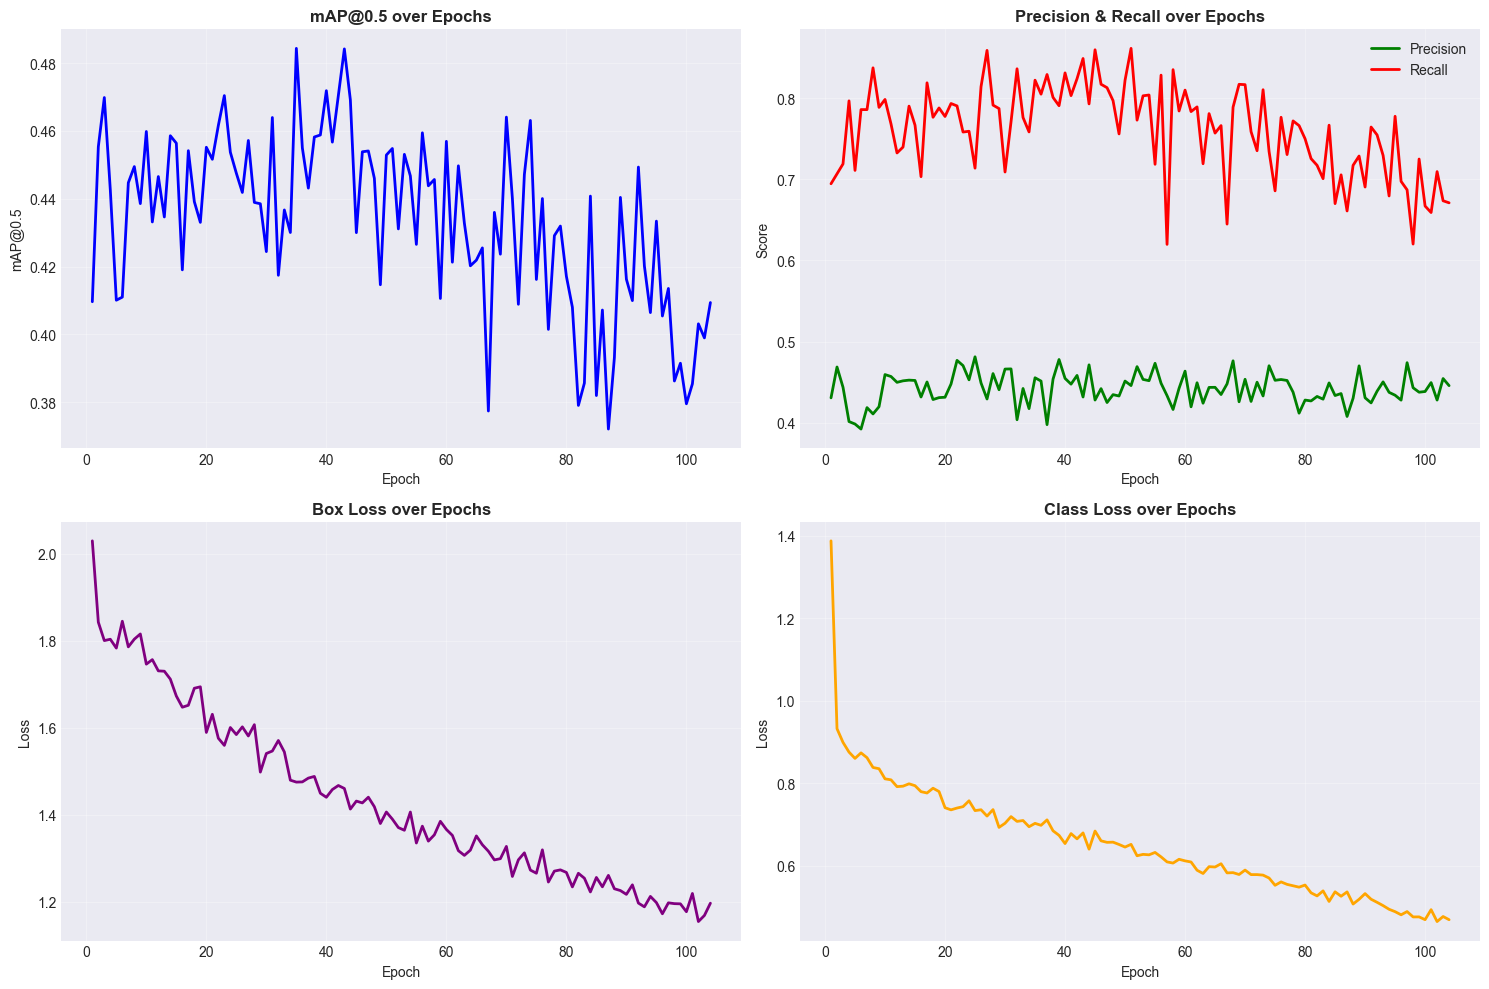

In [23]:
# Plot training curves
if yolov11m_results_path.exists():
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # mAP@0.5
    axes[0, 0].plot(yolov11m_df['epoch'], yolov11m_df['metrics/mAP50(B)'], 'b-', linewidth=2)
    axes[0, 0].set_title('mAP@0.5 over Epochs', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('mAP@0.5')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Precision & Recall
    axes[0, 1].plot(yolov11m_df['epoch'], yolov11m_df['metrics/precision(B)'], 'g-', label='Precision', linewidth=2)
    axes[0, 1].plot(yolov11m_df['epoch'], yolov11m_df['metrics/recall(B)'], 'r-', label='Recall', linewidth=2)
    axes[0, 1].set_title('Precision & Recall over Epochs', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Box Loss
    axes[1, 0].plot(yolov11m_df['epoch'], yolov11m_df['train/box_loss'], 'purple', linewidth=2)
    axes[1, 0].set_title('Box Loss over Epochs', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Class Loss
    axes[1, 1].plot(yolov11m_df['epoch'], yolov11m_df['train/cls_loss'], 'orange', linewidth=2)
    axes[1, 1].set_title('Class Loss over Epochs', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("Training results not available yet")

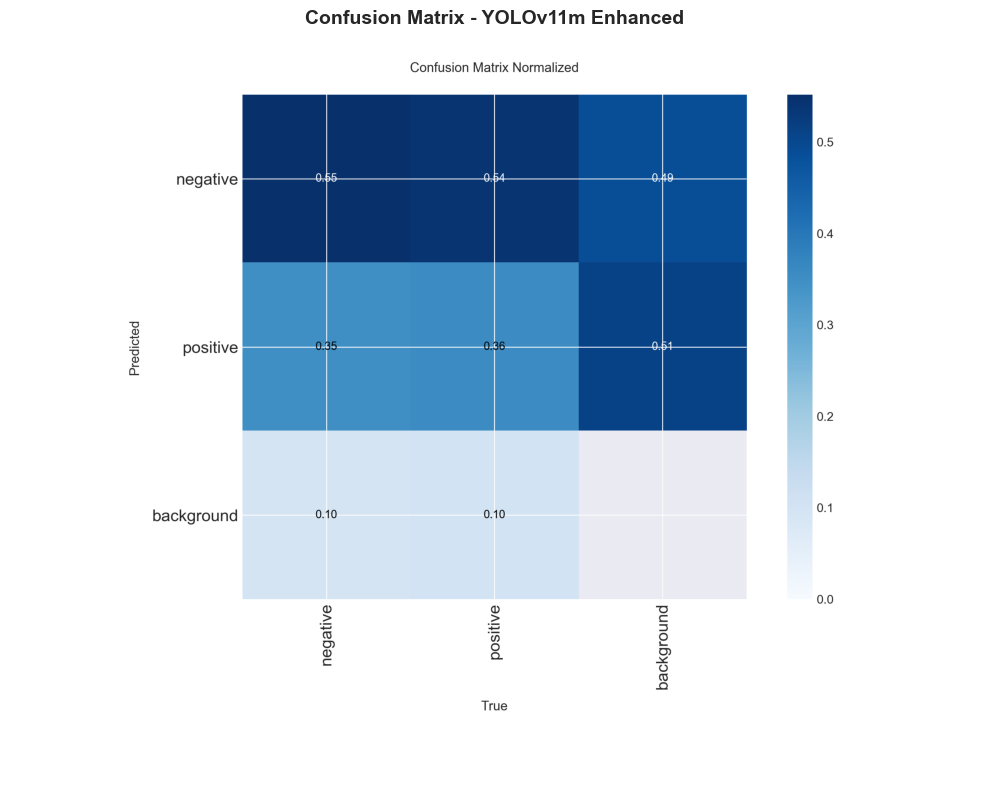

In [24]:
# Display confusion matrix
confusion_matrix_path = OUTPUT_DIR / 'yolov11m_enhanced' / 'confusion_matrix_normalized.png'

if confusion_matrix_path.exists():
    img = plt.imread(str(confusion_matrix_path))
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Confusion Matrix - YOLOv11m Enhanced', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
else:
    print("Confusion matrix not available yet - run training first!")

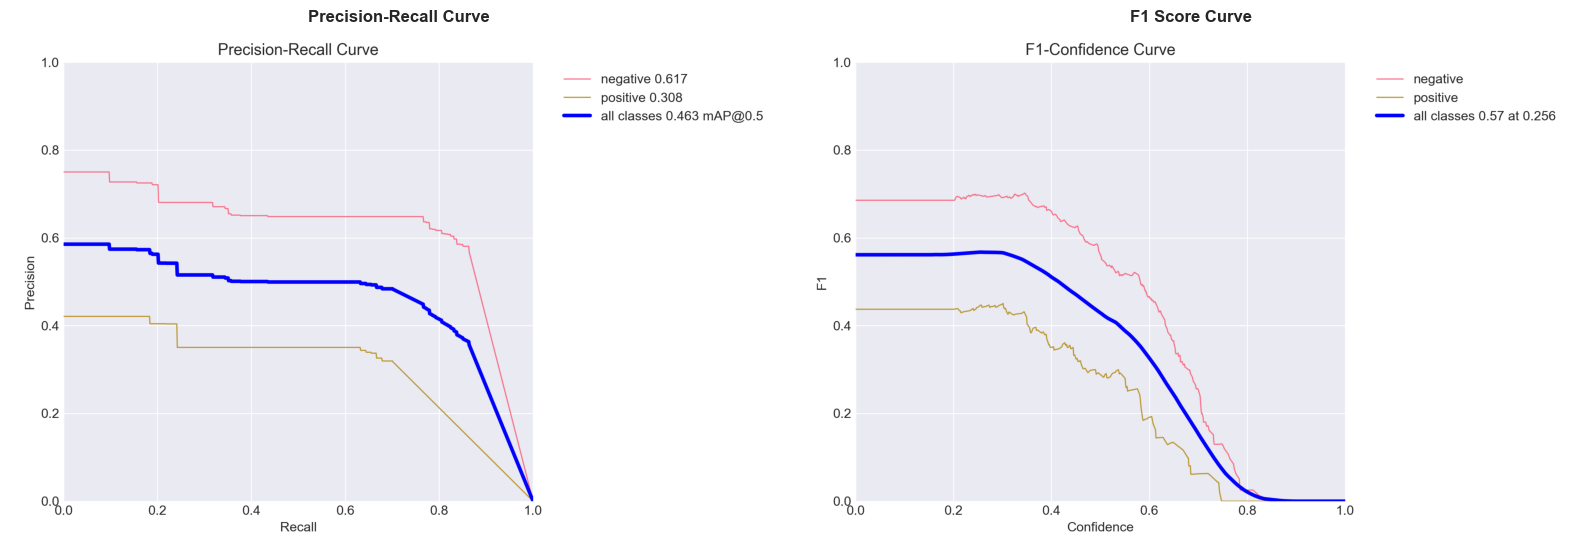

In [27]:
# Display PR and F1 curves
pr_curve_path = OUTPUT_DIR / 'yolov11m_enhanced' / 'BoxPR_curve.png'
f1_curve_path = OUTPUT_DIR / 'yolov11m_enhanced' / 'BoxF1_curve.png'

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

if pr_curve_path.exists():
    img = plt.imread(str(pr_curve_path))
    axes[0].imshow(img)
    axes[0].axis('off')
    axes[0].set_title('Precision-Recall Curve', fontsize=12, fontweight='bold')
else:
    axes[0].text(0.5, 0.5, 'PR Curve not available yet', ha='center', va='center')
    axes[0].axis('off')

if f1_curve_path.exists():
    img = plt.imread(str(f1_curve_path))
    axes[1].imshow(img)
    axes[1].axis('off')
    axes[1].set_title('F1 Score Curve', fontsize=12, fontweight='bold')
else:
    axes[1].text(0.5, 0.5, 'F1 Curve not available yet', ha='center', va='center')
    axes[1].axis('off')

plt.tight_layout()
plt.show()

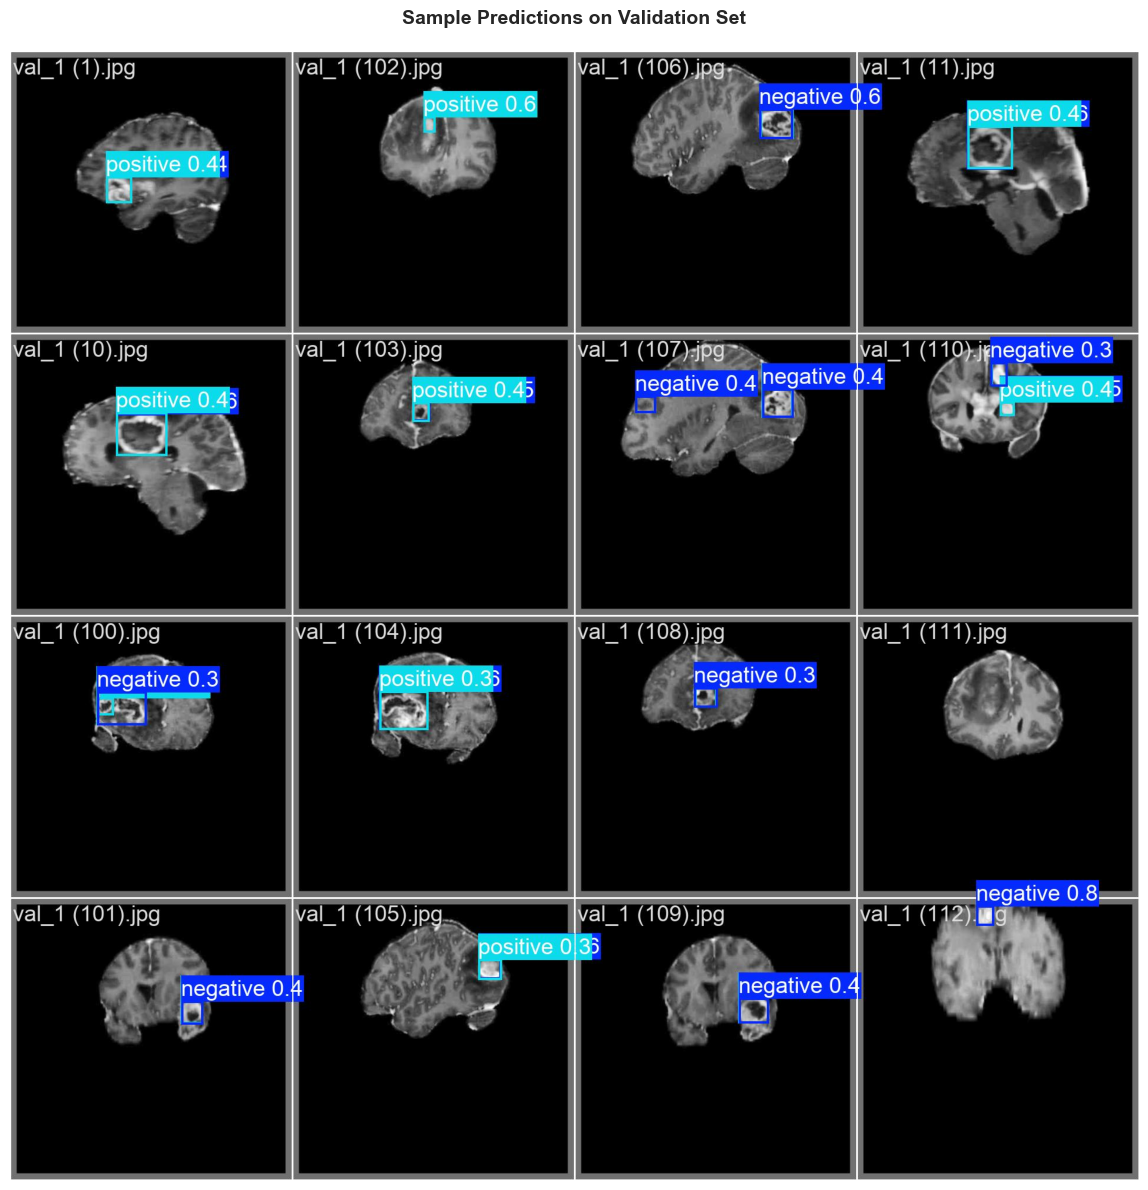


✓ Green boxes: Ground truth
✓ Blue boxes: Model predictions


In [28]:
# Show sample predictions from validation set
val_batch_path = OUTPUT_DIR / 'yolov11m_enhanced' / 'val_batch0_pred.jpg'

if val_batch_path.exists():
    img = plt.imread(str(val_batch_path))
    plt.figure(figsize=(16, 12))
    plt.imshow(img)
    plt.axis('off')
    plt.title('Sample Predictions on Validation Set', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    print("\n✓ Green boxes: Ground truth")
    print("✓ Blue boxes: Model predictions")
else:
    print("Prediction visualizations not available yet - run training first!")